In [1]:
import math
import os
import numpy as np
import pandas as pd

from collections import Counter
from matplotlib import pyplot as plt
from tqdm import tqdm

from data_dragon import DataDragon
from utils import load_game_data

In [2]:
data_folder = 'D:/fantasyai/data'
output_folder = 'output/stats'
figures_folder = os.path.join(output_folder, 'figs')
for folder in (output_folder, figures_folder):
    if not os.path.exists(folder):
        os.mkdir(folder)

Load item data from Dragontail

In [3]:
version = '11.15'
data_dragon = DataDragon(data_folder, version)
item_data = data_dragon.get_item_data()
rune_data = data_dragon.get_rune_data()
rune_names = {rune['id']: rune['name'] for path in rune_data for slot in path['slots'] for rune in slot['runes']}

Gather all entries of states and events

In [4]:
data = None

for id, game in tqdm(load_game_data(os.path.join(data_folder, 'aggregated'))):
    format = game['format']
    # Initialize data according to the game metadata (format)
    if data is None:
        data = {state_type: {'columns': [column for column in format['state'][state_type]],
                             'rows': []}
                for state_type in format['state'].keys()}
        for event_type in format['events'].keys():
            data[event_type] = {'columns': [column for column in format['events'][event_type]],
                                'rows': []}
        data['timesteps'] = {'columns': ['gameTime'],
                             'rows': []}
    for state_type in format['state'].keys():
        rows = [timestep_data['state'][state_type] for timestep_data in game['data']]
        while isinstance(rows[0][0], list):
            rows = [item for row in rows for item in row]
        data[state_type]['rows'].extend(rows)
    for timestep_data in game['data']:
        for event_type, event in timestep_data['events']:
            data[event_type]['rows'].append(event)
    data['timesteps']['rows'].extend([timestep_data['gameTime'] for timestep_data in game['data']])

for feature in data.keys():
    data[feature]['df'] = pd.DataFrame(data[feature].pop('rows', None), columns=data[feature]['columns'])

658it [02:43,  4.03it/s]


In [5]:
# Look for missing values in the data
for state_type in data.keys():
    df = data[state_type]['df']
    nan_rows = df[df.isna().any(axis=1)]
    assert nan_rows.size == 0

In [6]:
# Data that is stored as real values but is actually nominal and we are not interested in their mean and quantiles
nominal_data = ['itemID', 'skillSlot', 'perkID', 'participantID', 'participant', 'killer', 'winningTeam', 'transformer',
                'teamID', 'lastHitter', 'placer', 'victim']

csv_stats = [["Feature distributions"] if i == 0 else [""] for i in range(9)]
non_real = {}
for feature in data.keys():
    df = data[feature]['df']
    legal_columns = [column for column in df.columns if column not in nominal_data]
    undescribable_cols = list(df.columns.values)
    if legal_columns:
        description = df.describe()
        description = description[[column for column in description.columns if column in legal_columns]]
        # print(description)
        if 'mean' in description.axes[0]:
            print(feature, description.columns)
            csv_stats[0].extend(description.columns)
            for i, (name, row) in enumerate(description.iterrows()):
                csv_stats[i+1].extend(row)
            undescribable_cols = [column for column in df.columns if column not in description.columns]
    if undescribable_cols:
        print(f"Could not describe {feature}{undescribable_cols}")
        non_real[feature] = undescribable_cols

print(description)  # Show 1 example

with open(os.path.join(output_folder, 'distribution_stats.csv'), 'w') as f:
    for row in csv_stats:
        print(','.join(f"{f:.2}" if type(f) is float else f for f in row), file=f)

team_stats Index(['towerKills', 'assists', 'inhibKills', 'totalGold', 'championsKills',
       'deaths', 'dragonKills', 'baronKills'],
      dtype='object')
champion_state Index(['respawnTimer', 'level', 'XP', 'health', 'healthMax', 'healthRegen',
       'magicPenetration', 'magicPenetrationPercent',
       'magicPenetrationPercentBonus', 'armorPenetration',
       'armorPenetrationPercent', 'armorPenetrationPercentBonus',
       'currentGold', 'totalGold', 'goldPerSecond', 'shutdownValue',
       'primaryAbilityResource', 'primaryAbilityResourceMax',
       'primaryAbilityResourceRegen', 'attackDamage', 'attackSpeed',
       'abilityPower', 'cooldownReduction', 'lifeSteal', 'spellVamp', 'armor',
       'magicResist', 'ccReduction', 'ultimateCooldownRemaining'],
      dtype='object')
Could not describe champion_state['championName', 'alive', 'position', 'ultimateName']
team_building_respawns Index(['inhibitor_top_respawn', 'inhibitor_mid_respawn',
       'inhibitor_bot_respawn'],
     

Compute stats for events, plot positions

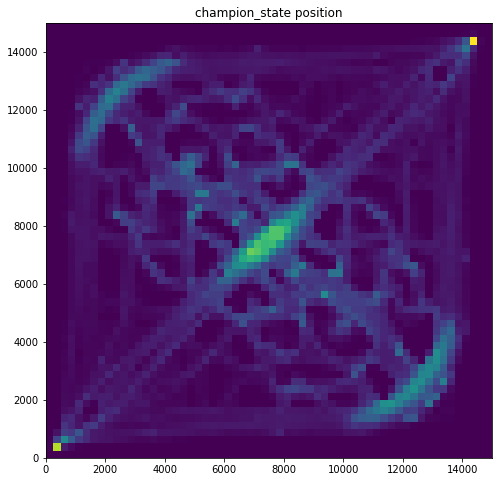

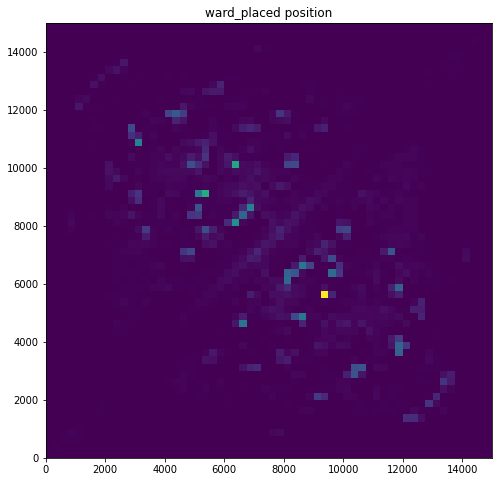

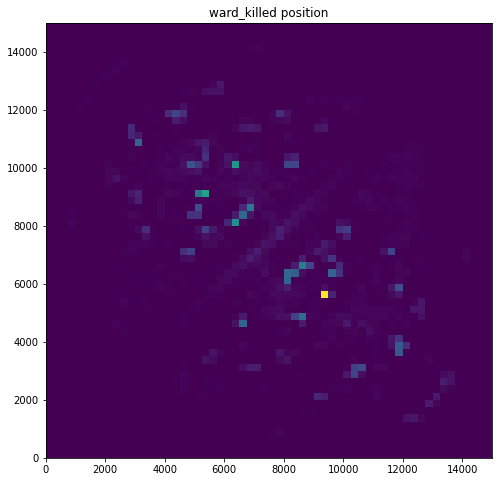

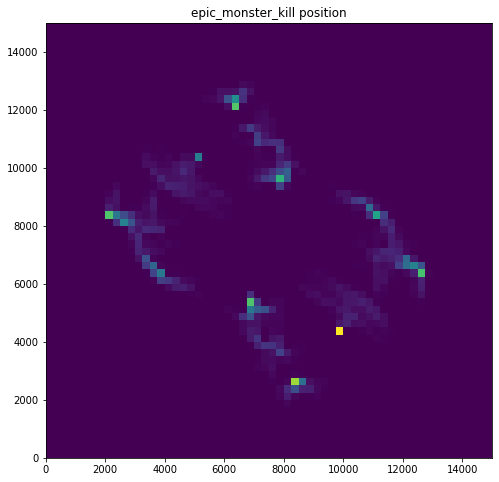

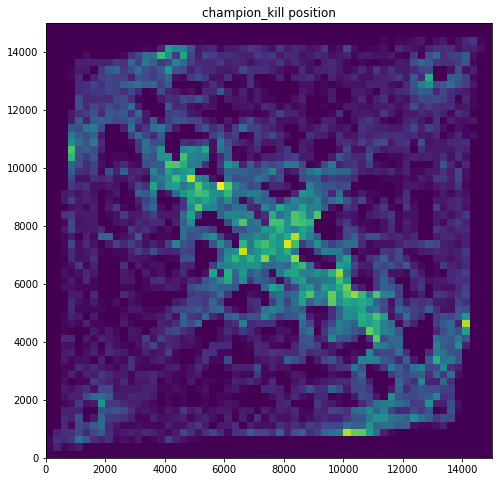

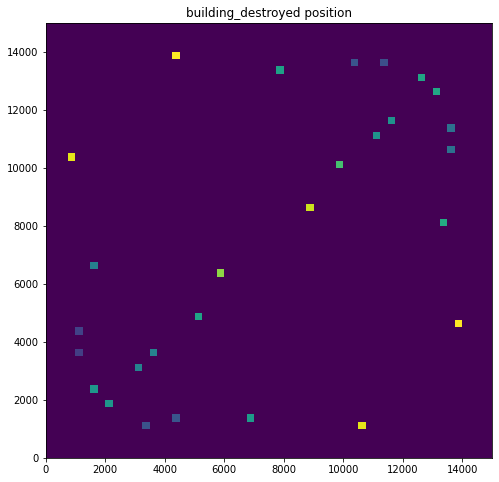

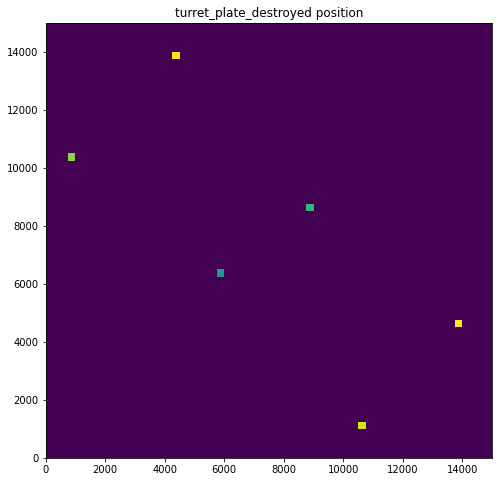

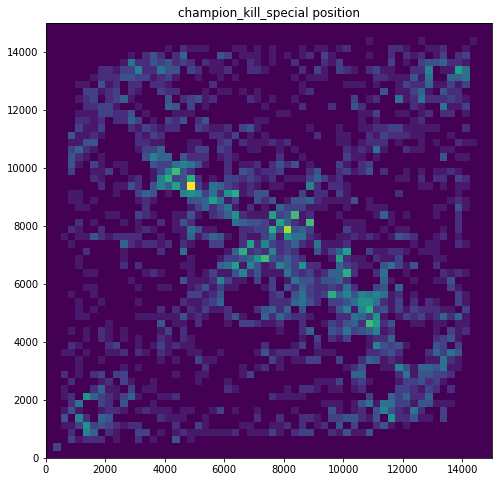

In [7]:
assistants_csv_stats = [["Event assistant frequencies"]] + [[i] for i in range(1, 11)]
assistants_size_csv_stats = [["Event assistant count distribution"]] + [[""] for i in range(8)]
item_participant_csv_stats = [["Item event participant frequencies"]] + [[i] for i in range(1, 11)]
item_id_stats = []


for feature in non_real.keys():
    df = data[feature]['df']
    columns = non_real[feature]
    for column in columns:
        if column == 'participantID':
            value_counts = Counter(df[column])
            item_participant_csv_stats[0].append(feature)
            if 0 in value_counts:
                raise ValueError
            for i in range(1, 11):
                item_participant_csv_stats[i].append(value_counts[i])
        elif column == 'itemID':
            value_counts = Counter(df[column])
            item_id_stats.append((feature, value_counts))
        elif column == 'perkID':
            value_counts = Counter(df[column])
            rows = [[f'{feature}.{column}', 'name', 'count']]
            rows.extend([[key, rune_names[key] if key in rune_names else "UNKNOWN", value] for key, value in value_counts.items()])
            with open(os.path.join(output_folder, f'{feature}_{column}_stats.csv'), 'w') as f:
                for row in rows:
                    print(','.join(map(str, row)), file=f)
        elif column == 'ultimateName':  #FIXME: This is necessary due to a bug where sometimes the name is lower case
            value_counts = Counter(df[column].map(lambda x: x.lower()))
            rows = [[f'{feature}.{column}', "count"]]
            rows.extend([[key, value] for key, value in value_counts.items()])
            with open(os.path.join(output_folder, f'{feature}_{column}_stats.csv'), 'w') as f:
                for row in rows:
                    print(','.join(map(str, row)), file=f)
        elif column not in ('position', 'assistants'):
            # categorical
            value_counts = Counter(df[column])
            rows = [[f'{feature}.{column}', "count"]]
            rows.extend([[key, value] for key, value in value_counts.items()])
            with open(os.path.join(output_folder, f'{feature}_{column}_stats.csv'), 'w') as f:
                for row in rows:
                    print(','.join(map(str, row)), file=f)
        elif column == 'position':
            rows = [["", "x", "y"],
                    ["min", min([i['x'] for i in df[column]]), min([i['z'] for i in df[column]])],
                    ["max", max([i['x'] for i in df[column]]), max([i['z'] for i in df[column]])]]
            plt.figure(figsize=(8,8))
            plt.hist2d([i['x'] for i in df[column]], [i['z'] for i in df[column]], bins=60, range=([0, 15000], [0, 15000]))
            plt.savefig(os.path.join(figures_folder, f'{feature}_{column}.png'), facecolor='white', transparent=False)
            plt.title(f'{feature} {column}')  # Save figures without the title
            plt.show()
        elif column == 'assistants':
            sizes = [len(item) for item in df[column]]
            sizes_df = pd.DataFrame(sizes, columns=[f'{feature} count'])
            description = sizes_df.describe()

            assistants_size_csv_stats[0].append(f'{feature} count')
            for i, (name, row) in enumerate(description.iterrows()):
                assistants_size_csv_stats[i+1].extend(row)

            value_counts = Counter((assistant for assistants in df[column] for assistant in assistants))
            assistants_csv_stats[0].append(feature)
            if 0 in value_counts:
                raise ValueError
            for i in range(1, 11):
                assistants_csv_stats[i].append(value_counts[i])
        else:
            raise NotImplementedError

with open(os.path.join(output_folder, f'assistants_stats.csv'), 'w') as f:
    for row in assistants_csv_stats:
        print(','.join(map(str, row)), file=f)

with open(os.path.join(output_folder, f'assistants_sizes_distributions_stats.csv'), 'w') as f:
    for row in assistants_size_csv_stats:
        print(','.join(f"{f:.2}" if type(f) is float else f for f in row), file=f)

with open(os.path.join(output_folder, f'item_participant_stats.csv'), 'w') as f:
    for row in item_participant_csv_stats:
        print(','.join(map(str, row)), file=f)

with open(os.path.join(output_folder, f'item_id_stats.csv'), 'w') as f:
    unique_ids = set([key for _, counter in item_id_stats for key in counter.keys()])
    print(','.join(['itemID', 'name'] + [name for name, _ in item_id_stats]), file=f)
    for id in unique_ids:
        item_name = item_data['data'][str(id)]['name'] if str(id) in item_data['data'] else "UNKNOWN"
        print(','.join([str(id), item_name] + [str(counter[id]) for _, counter in item_id_stats]), file=f)


Plot features

<ipython-input-8-6953349504db>:11: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.object or dtype == np.bool or column in categorical:
<ipython-input-8-6953349504db>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif dtype == np.object or dtype == np.bool or column in categorical:


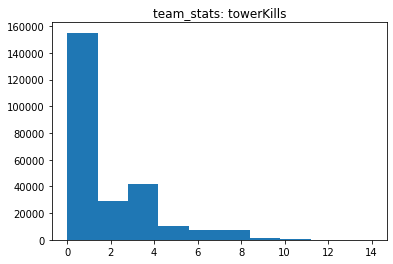

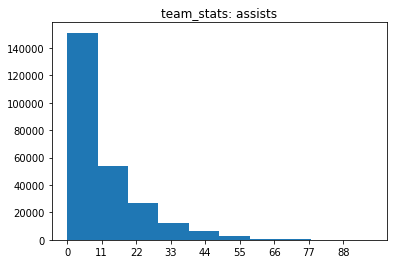

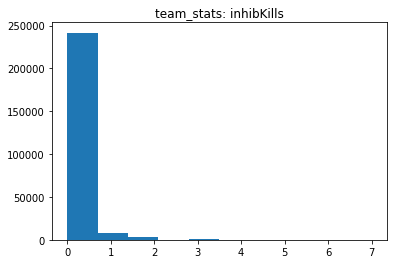

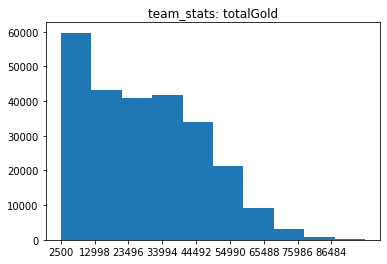

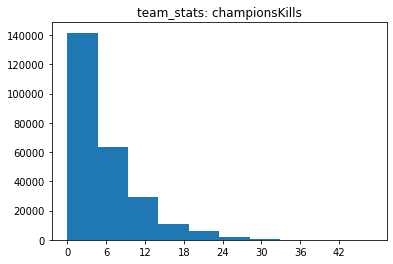

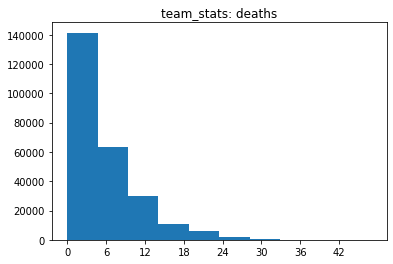

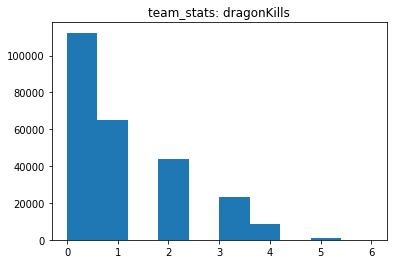

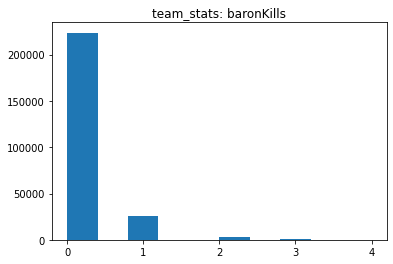

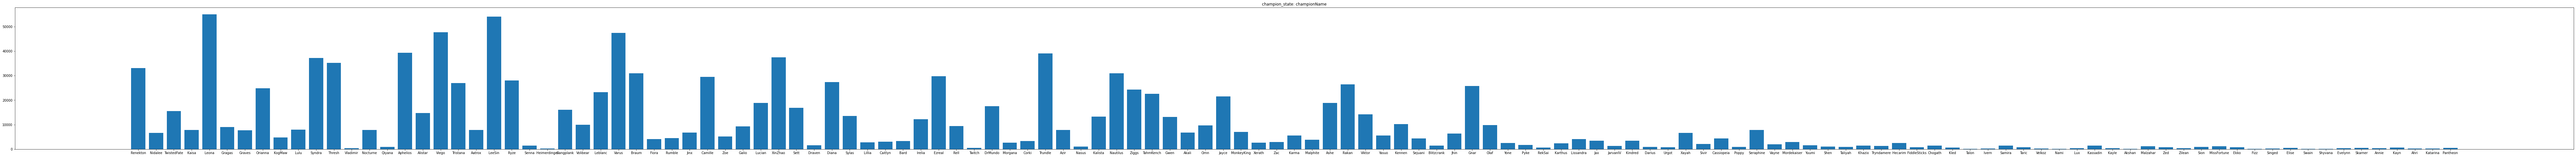

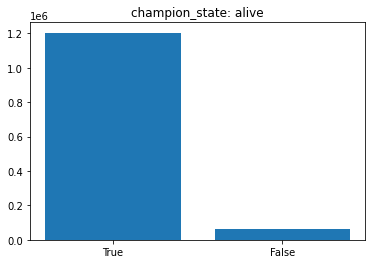

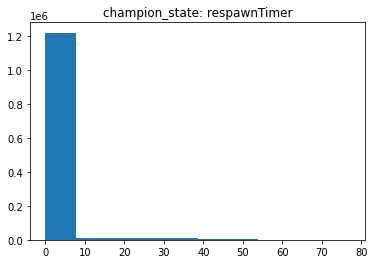

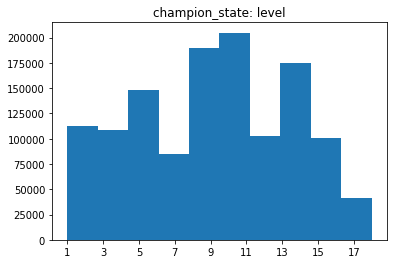

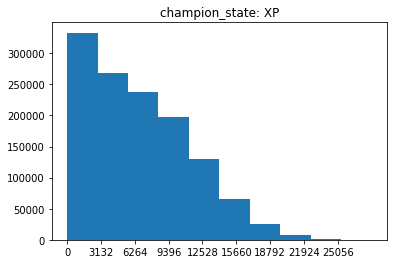

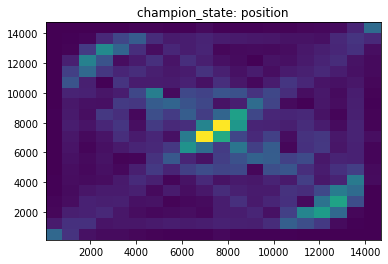

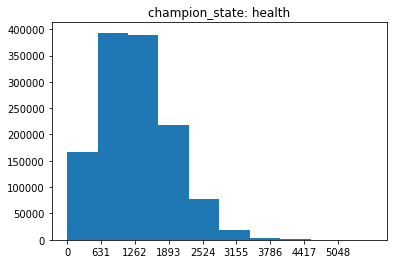

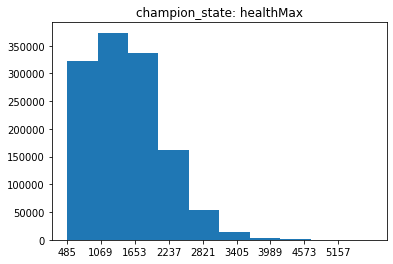

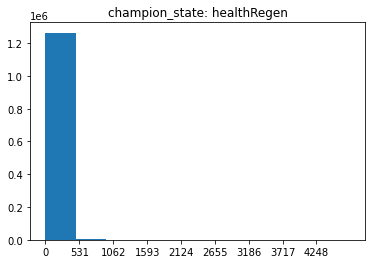

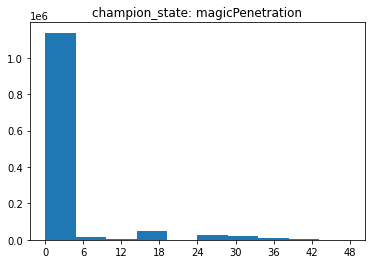

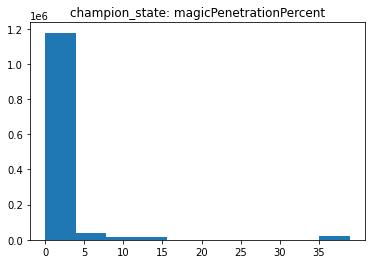

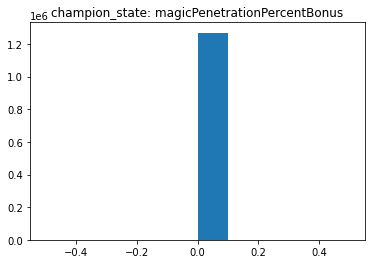

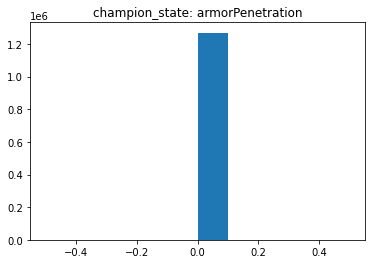

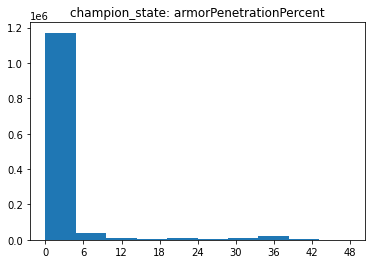

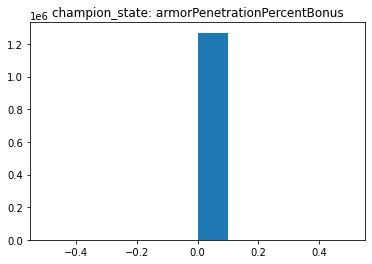

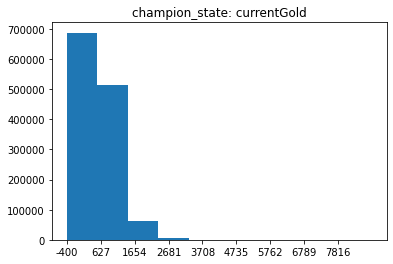

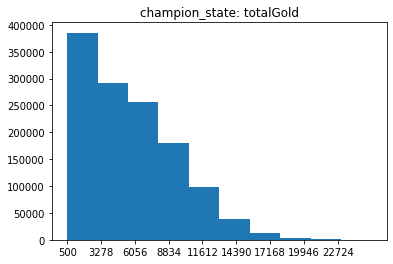

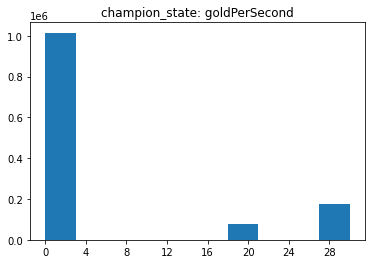

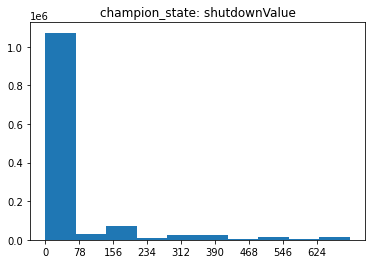

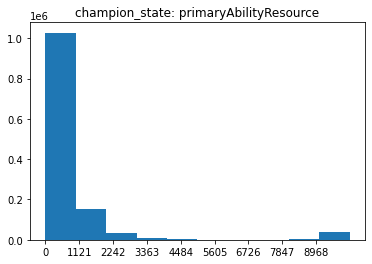

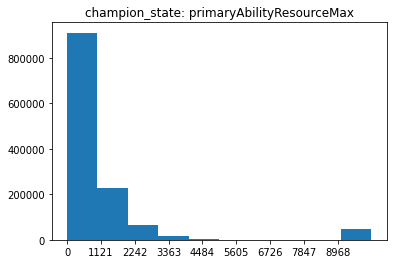

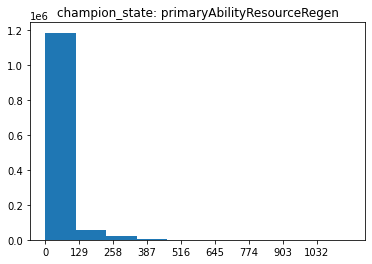

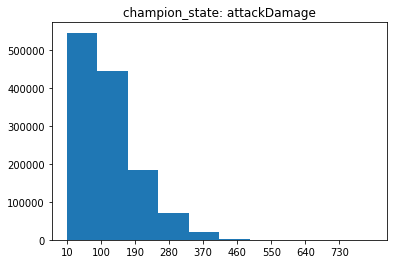

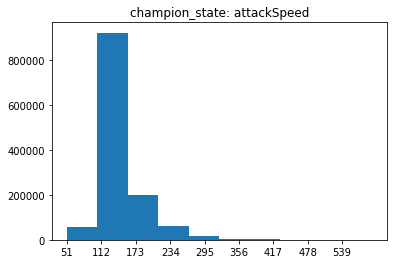

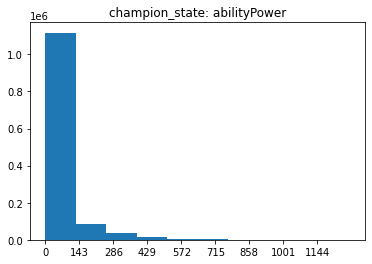

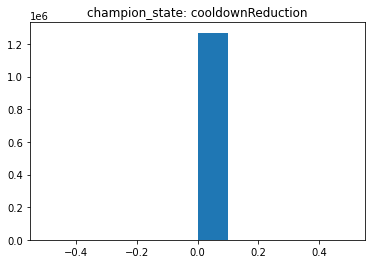

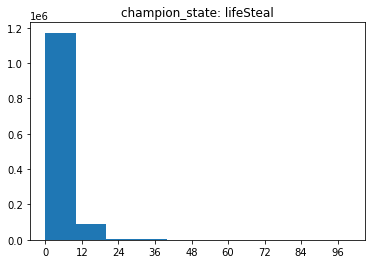

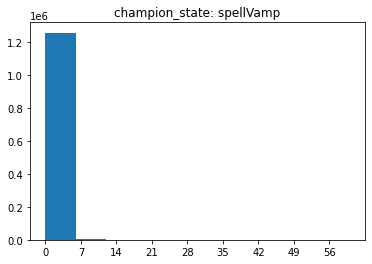

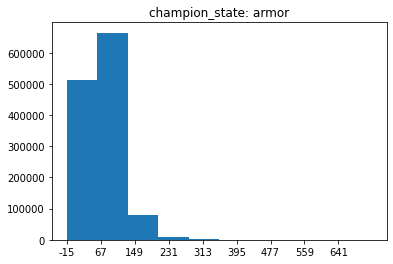

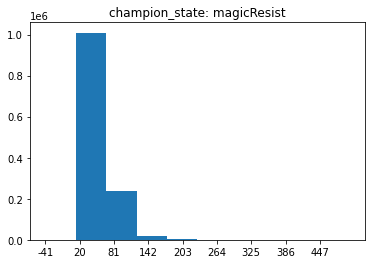

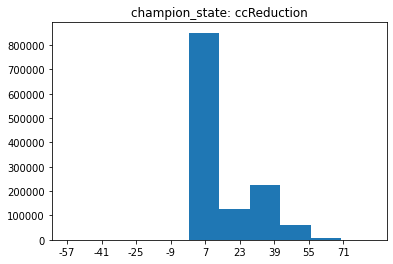

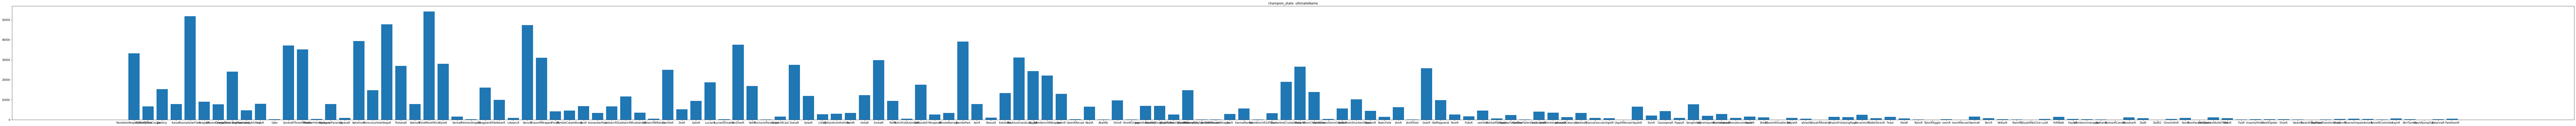

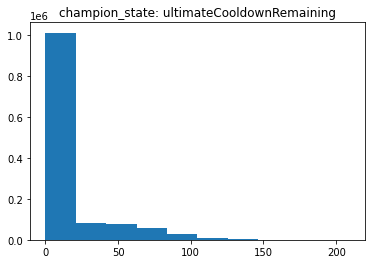

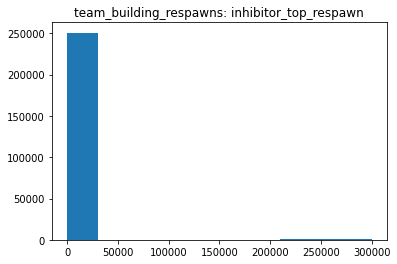

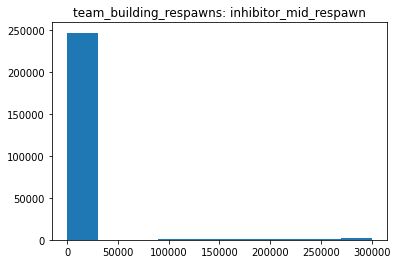

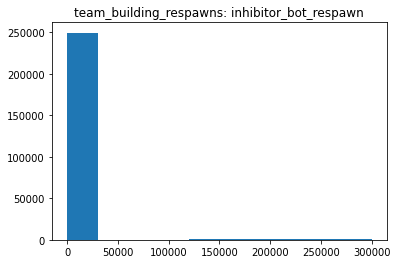

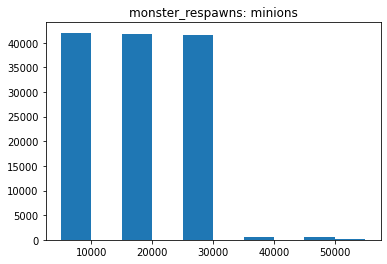

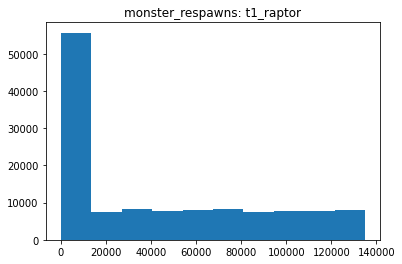

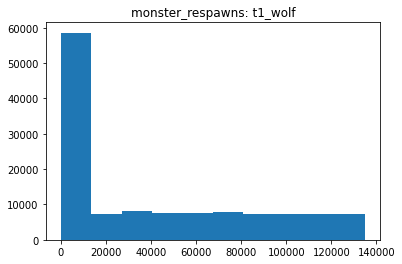

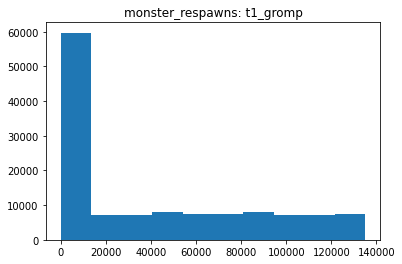

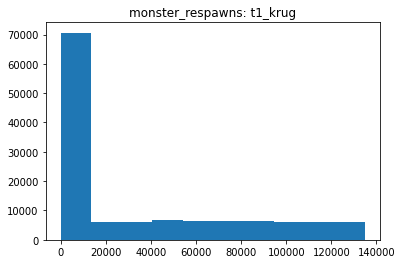

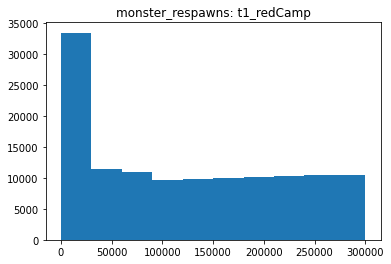

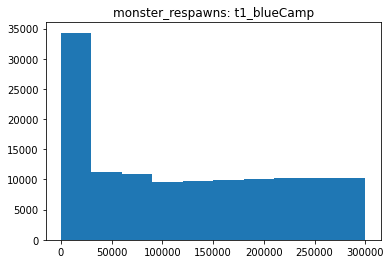

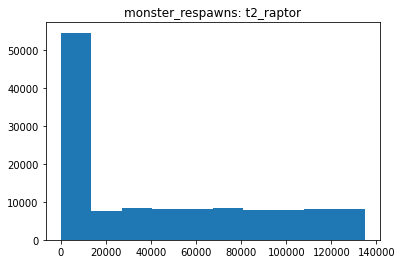

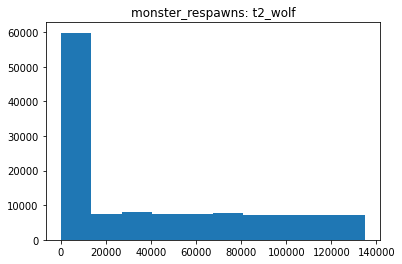

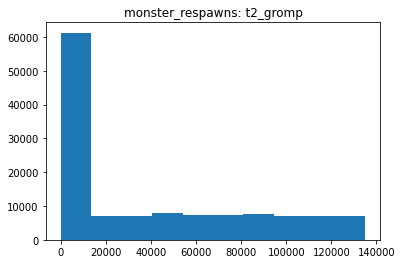

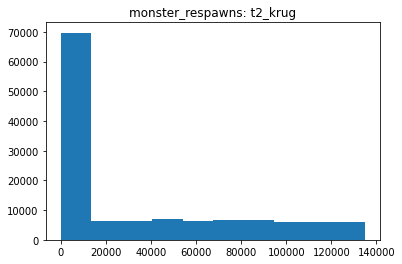

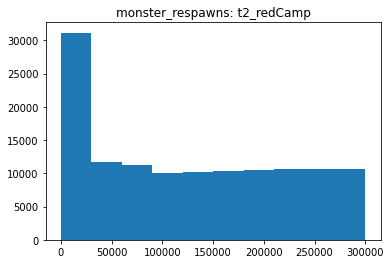

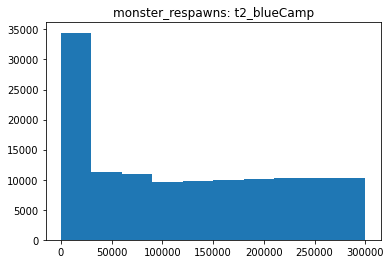

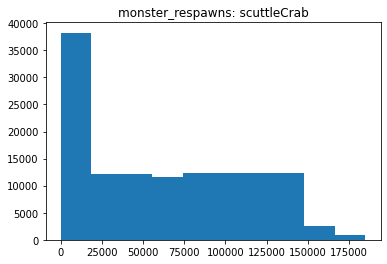

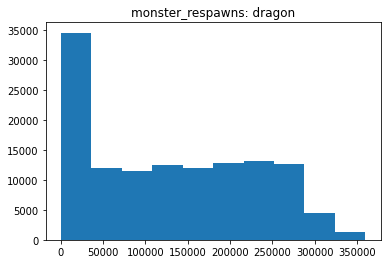

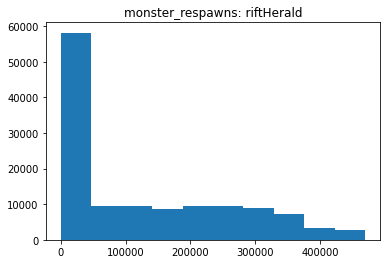

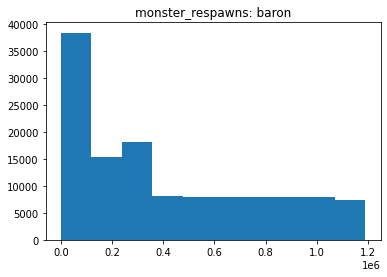

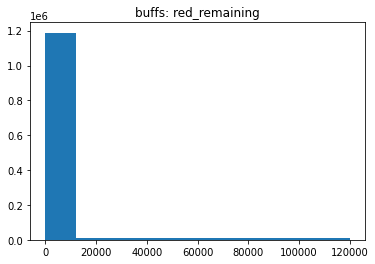

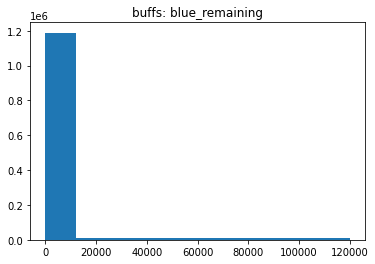

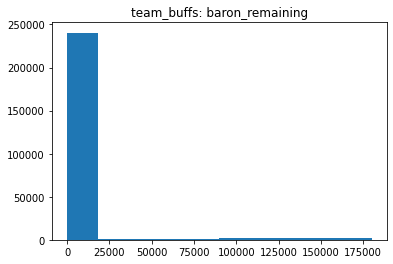

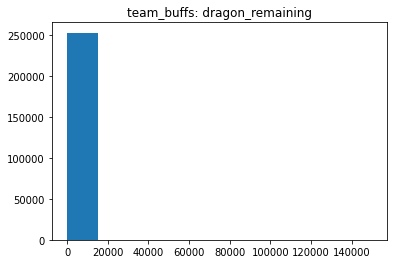

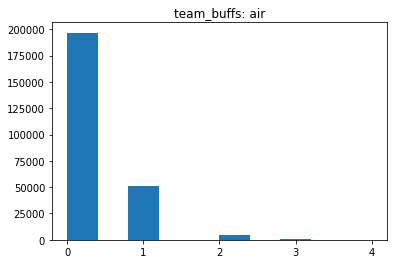

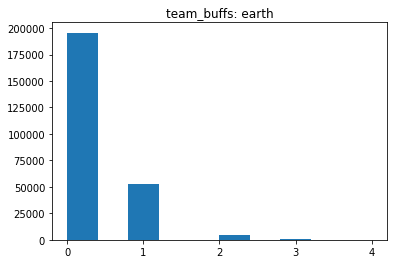

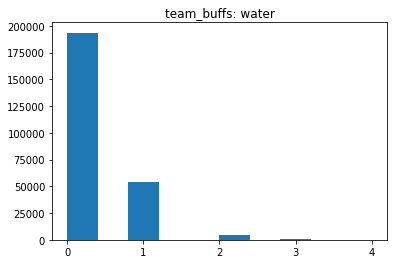

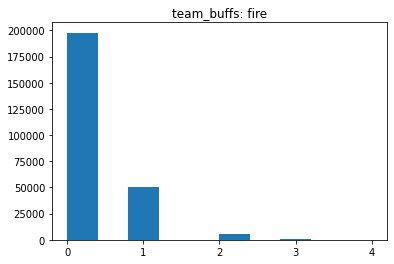

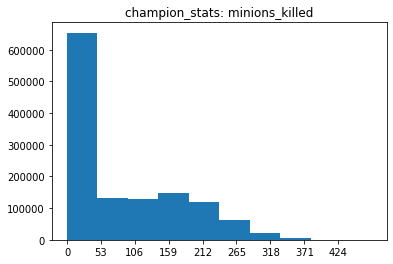

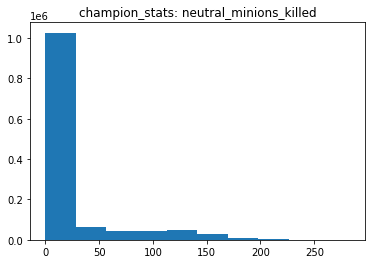

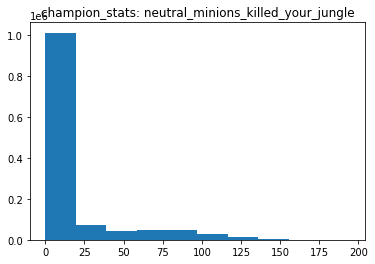

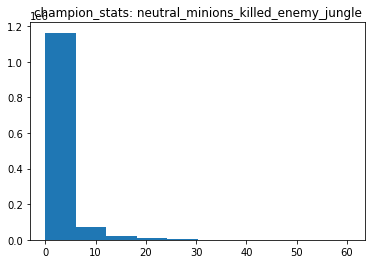

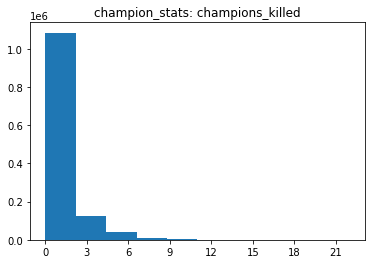

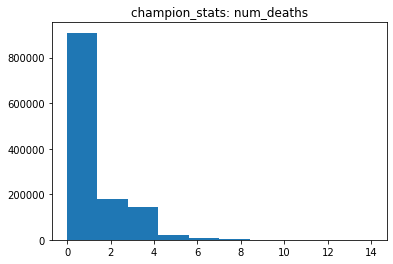

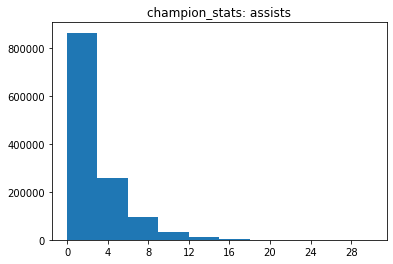

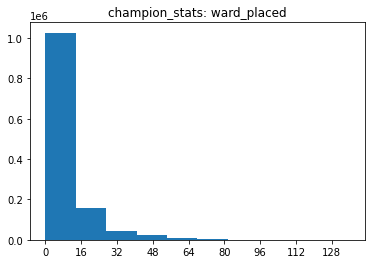

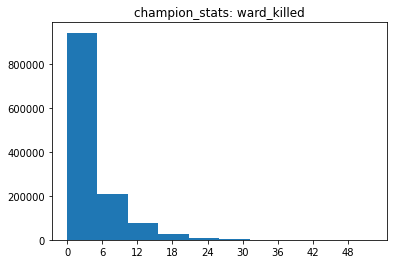

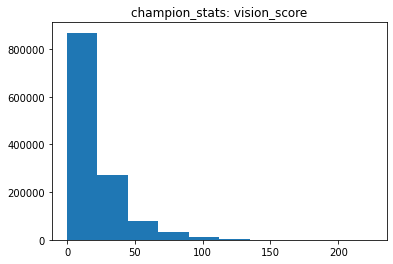

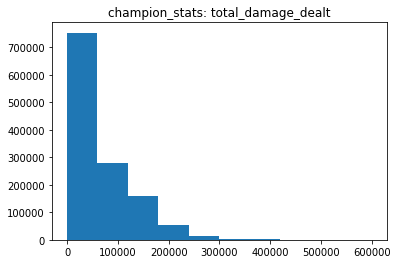

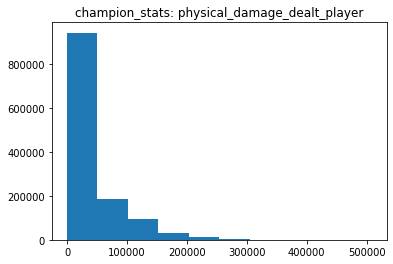

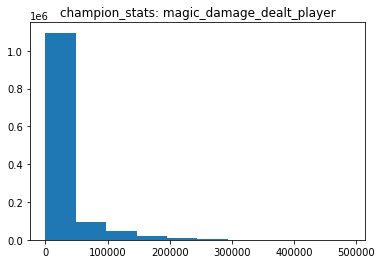

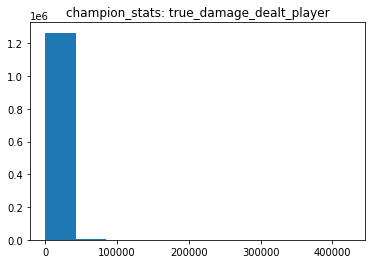

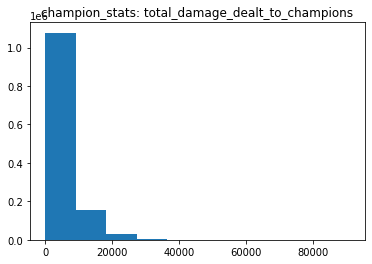

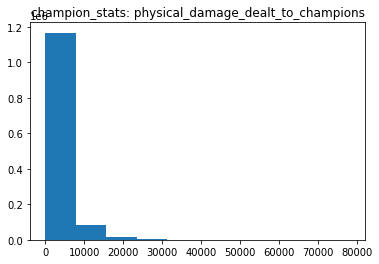

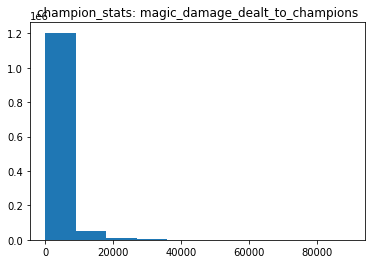

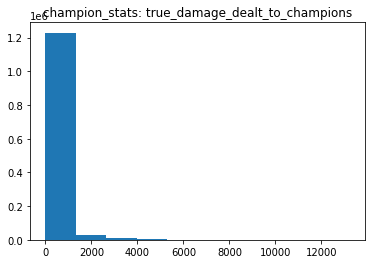

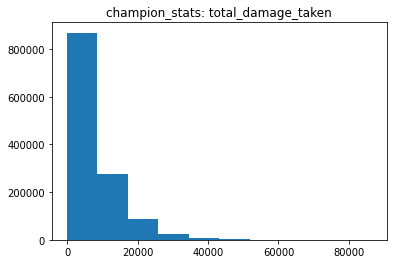

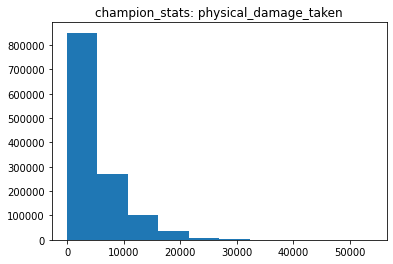

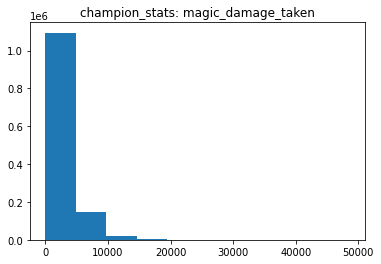

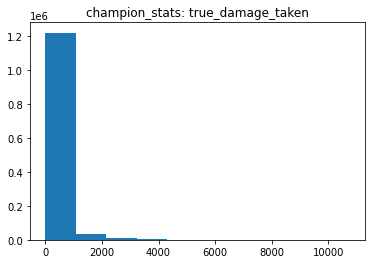

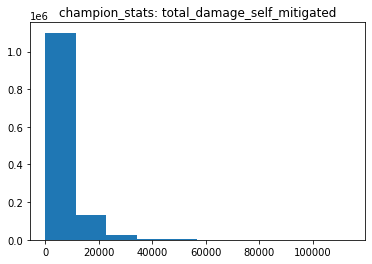

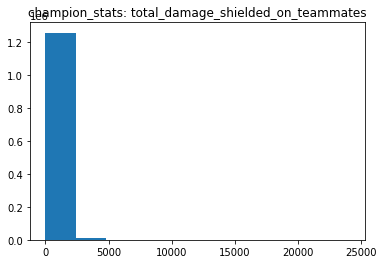

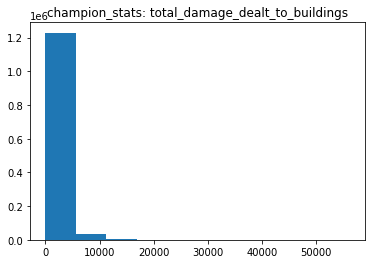

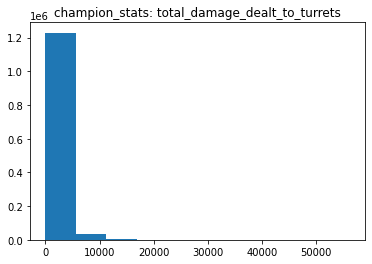

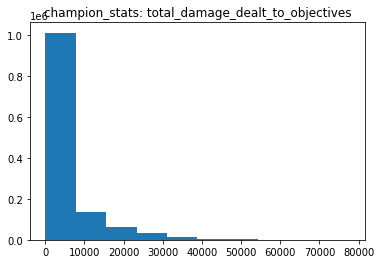

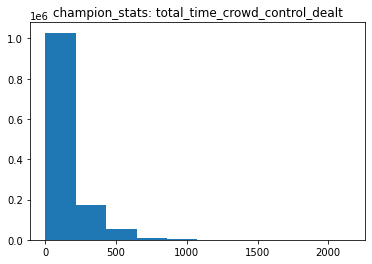

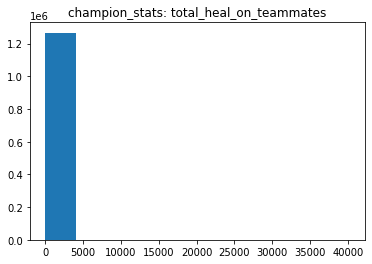

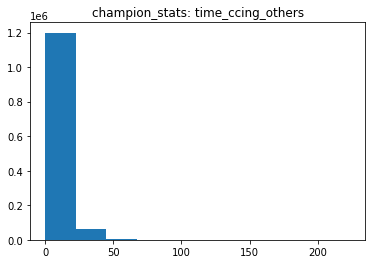

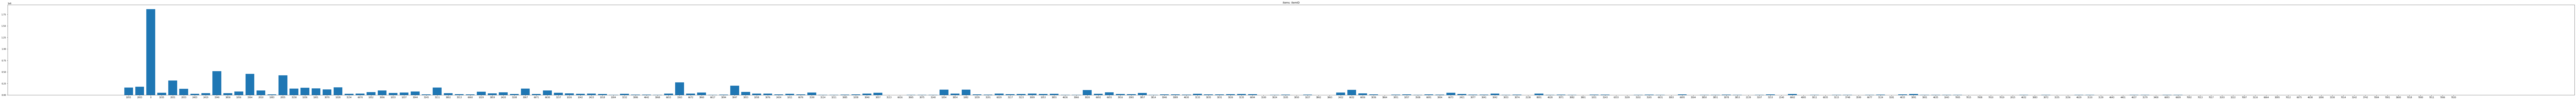

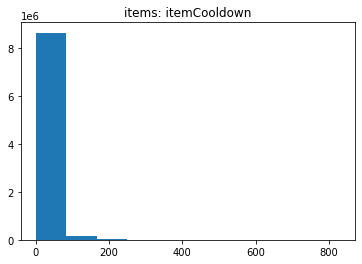

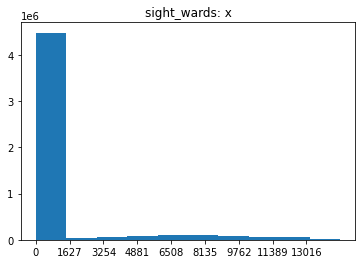

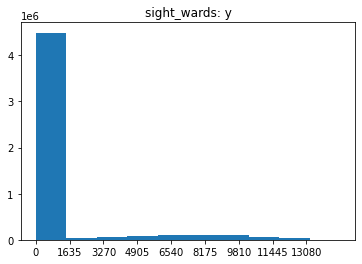

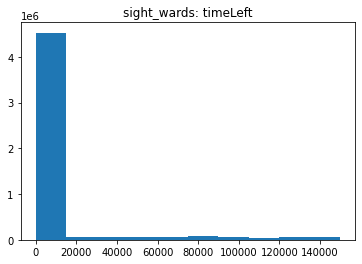

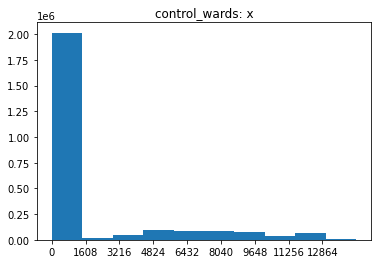

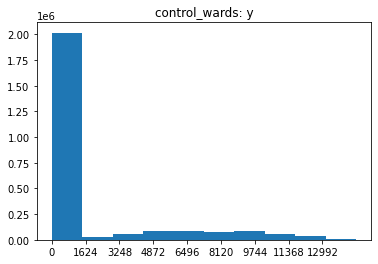

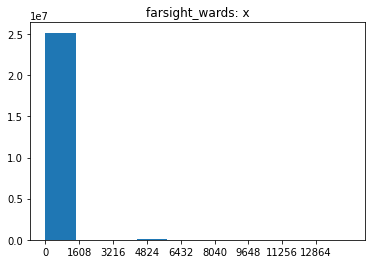

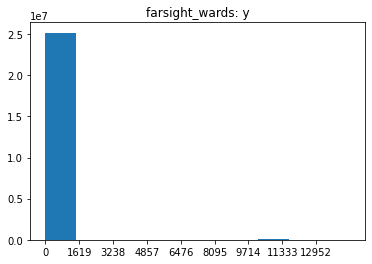

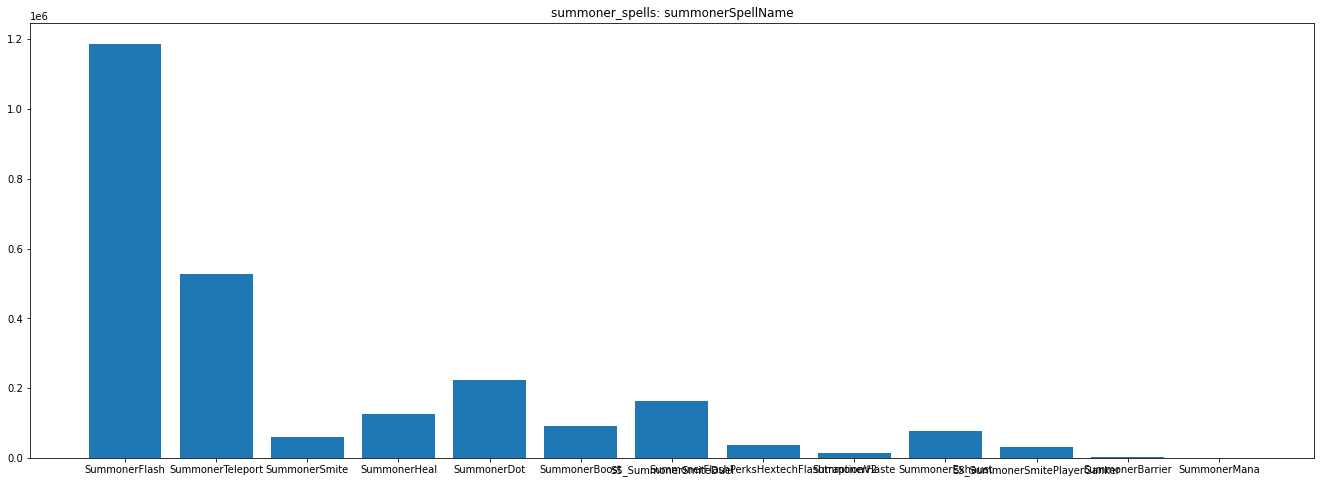

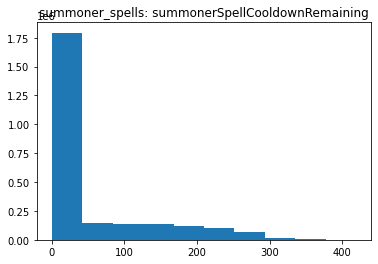

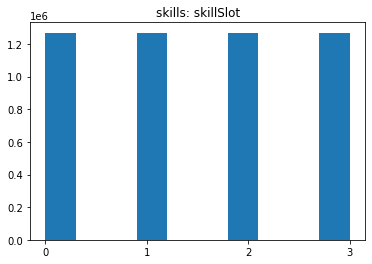

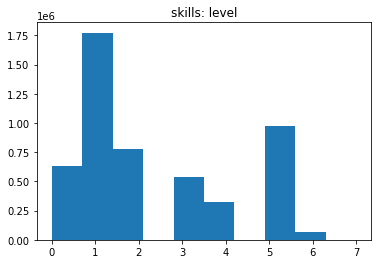

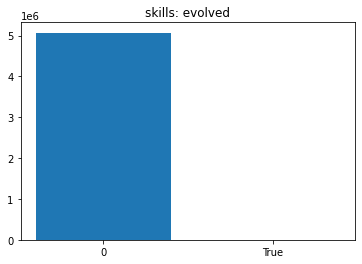

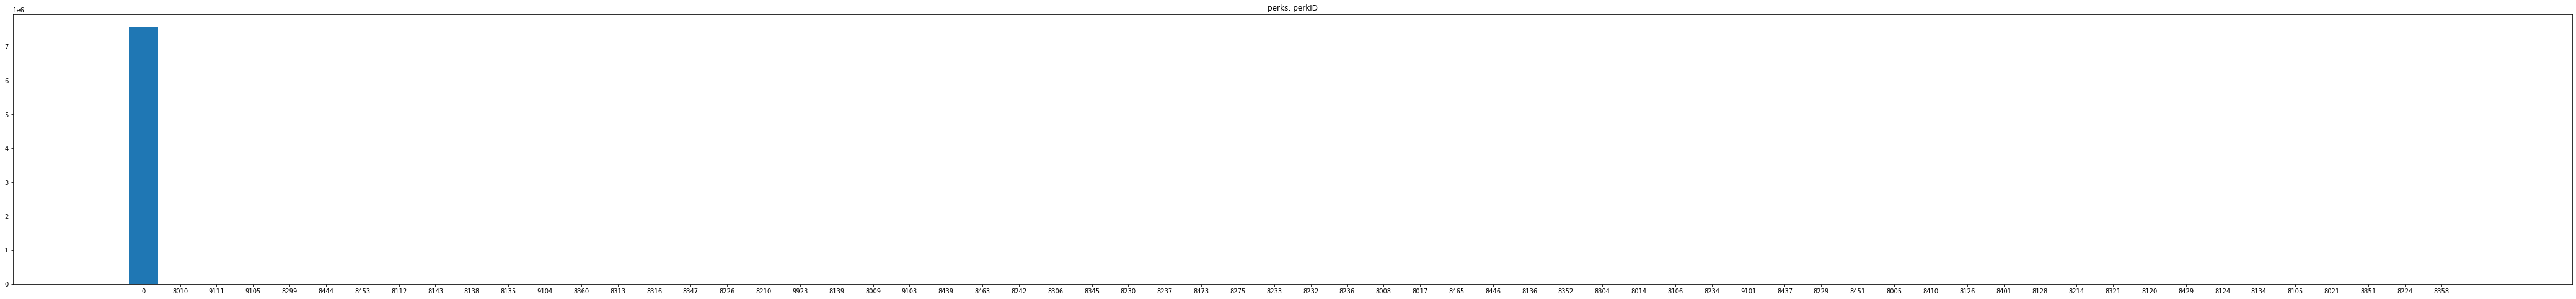

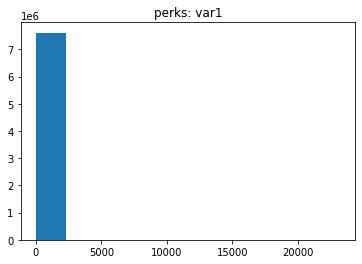

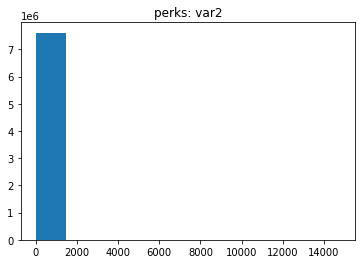

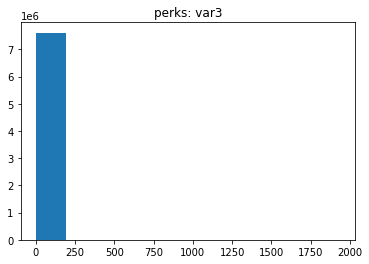

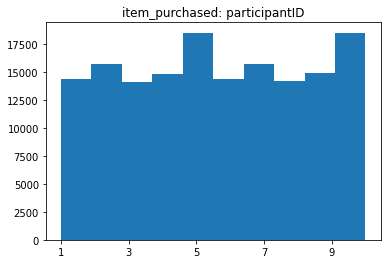

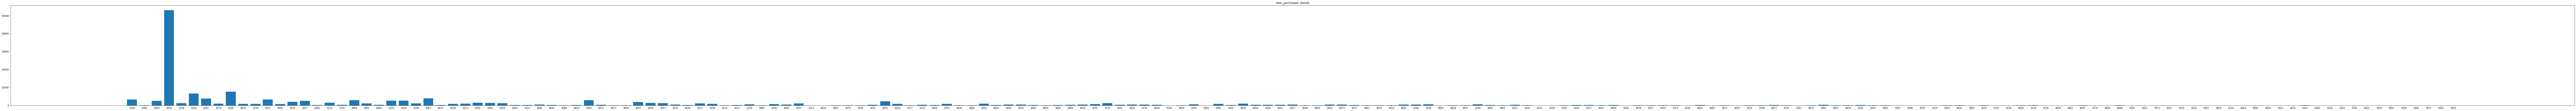

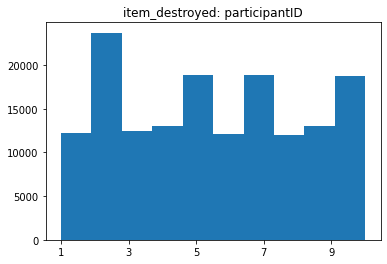

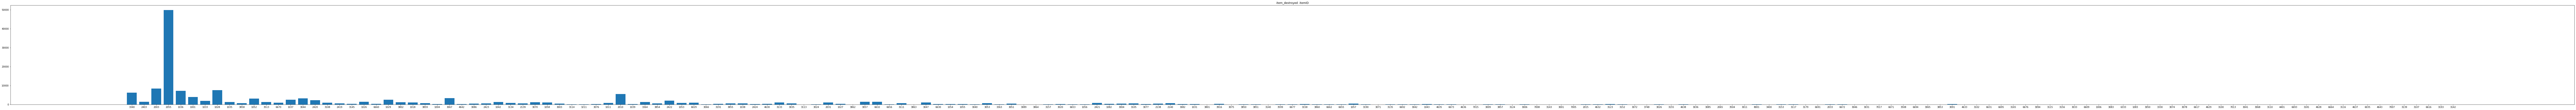

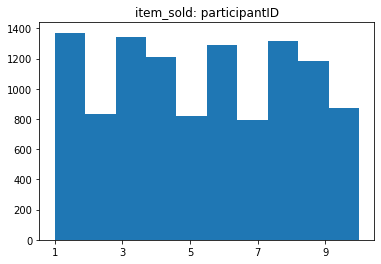

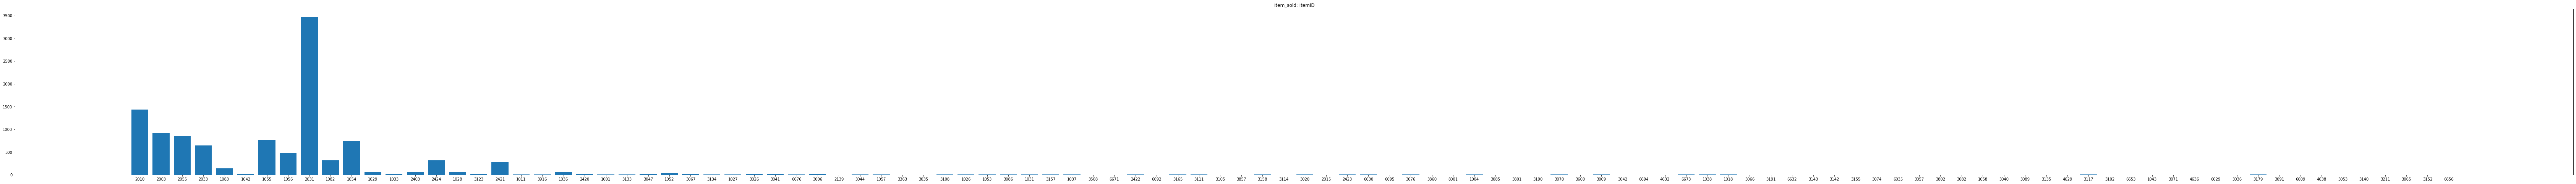

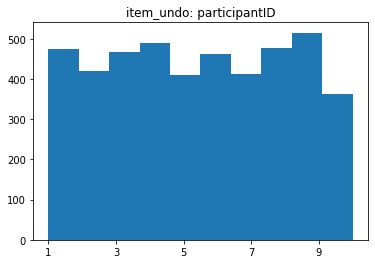

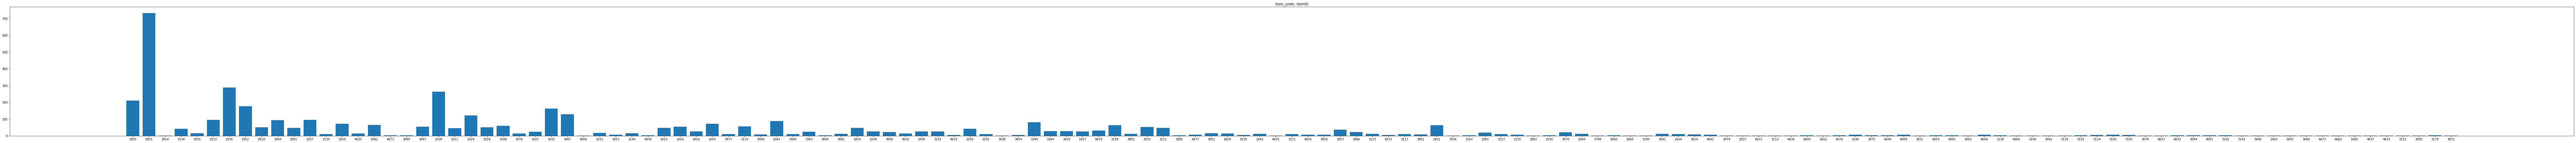

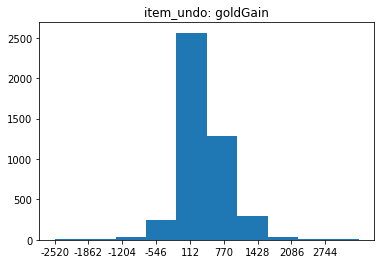

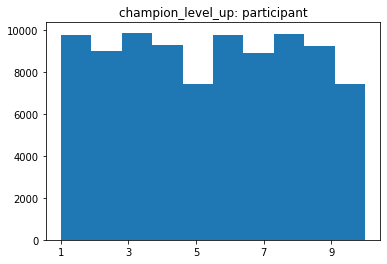

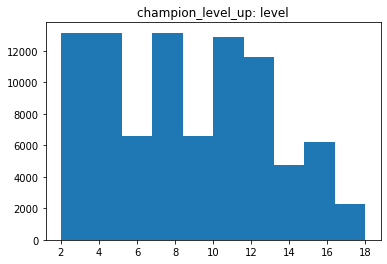

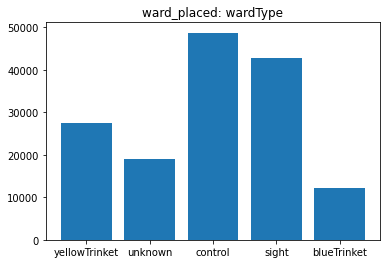

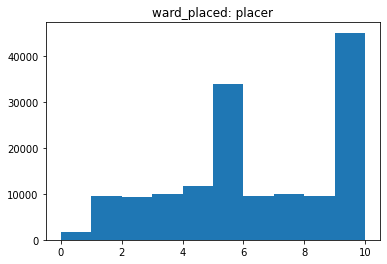

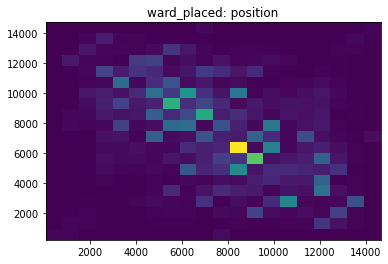

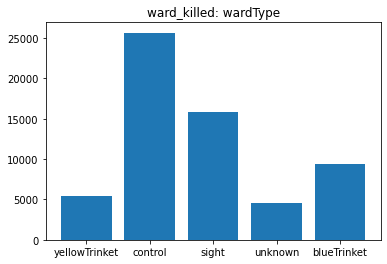

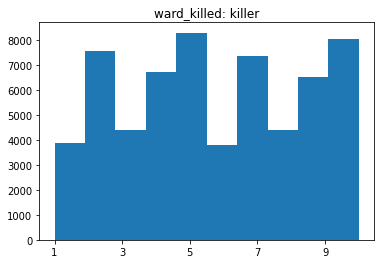

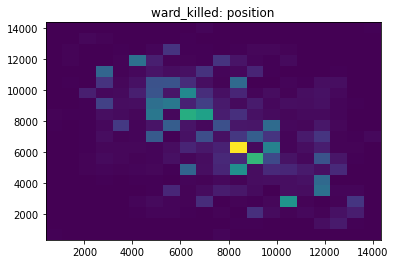

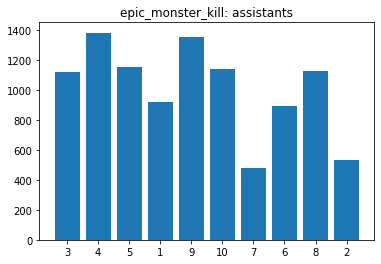

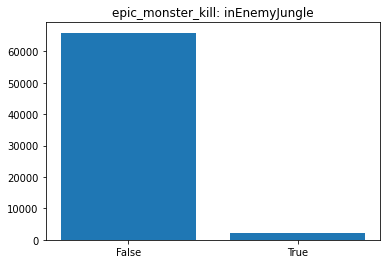

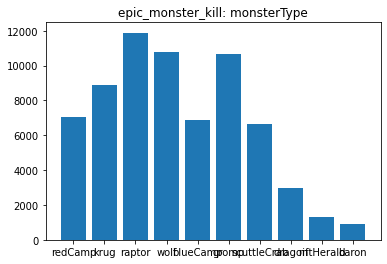

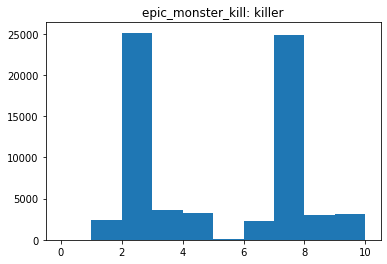

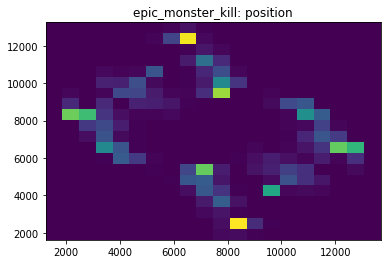

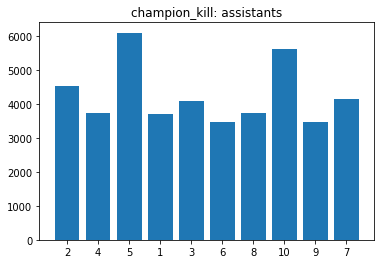

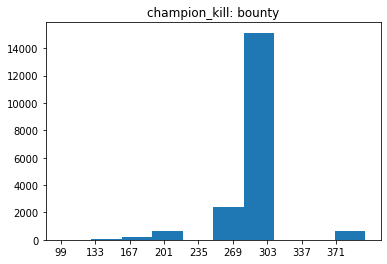

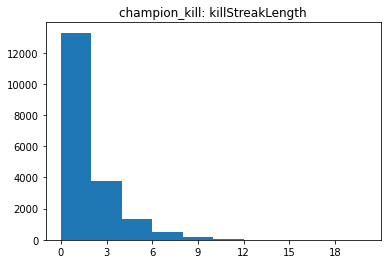

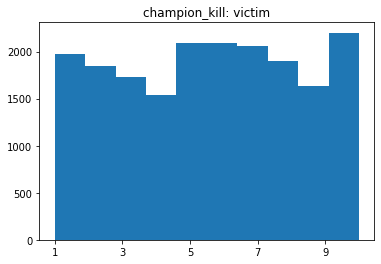

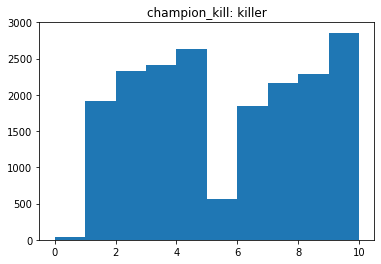

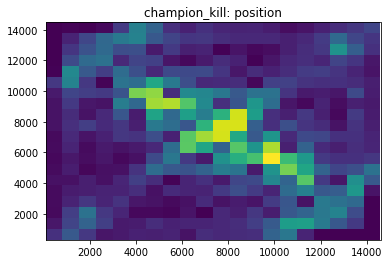

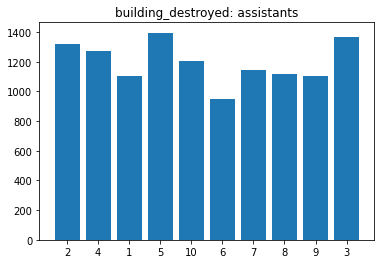

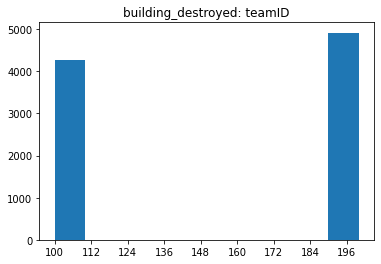

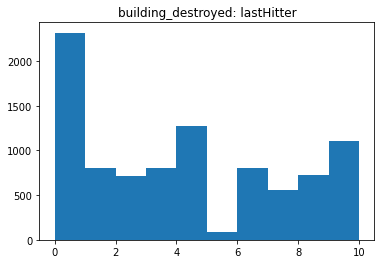

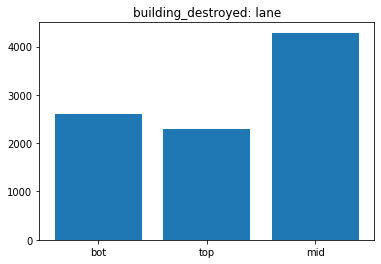

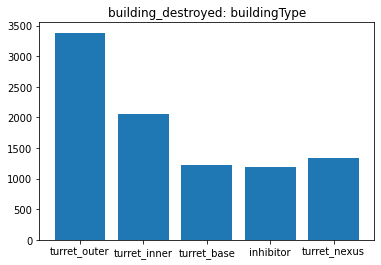

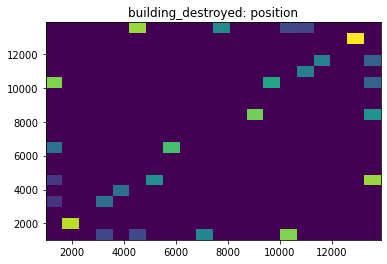

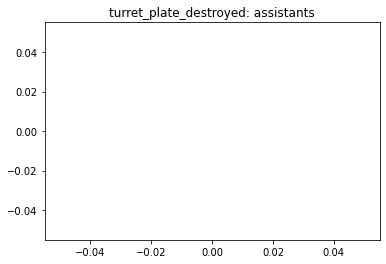

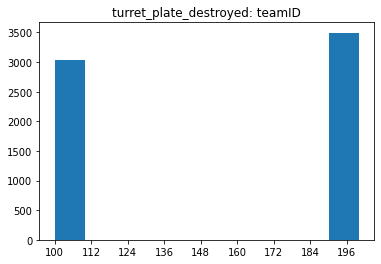

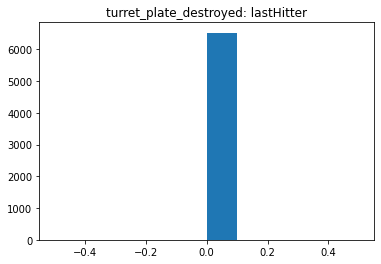

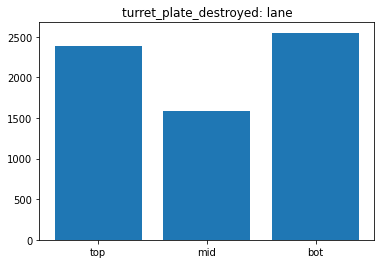

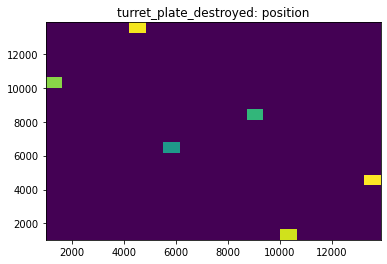

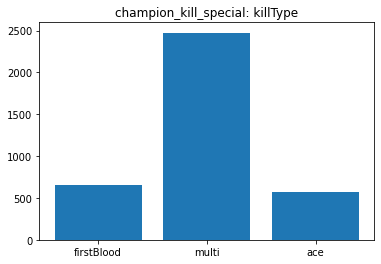

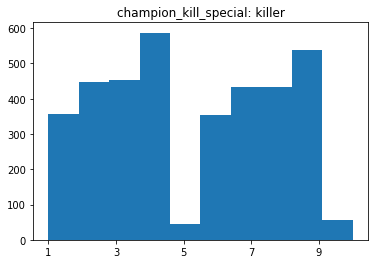

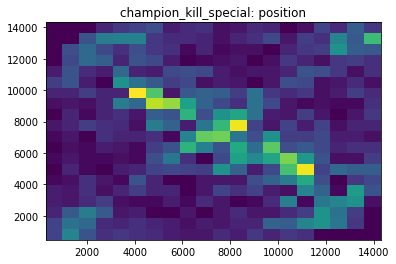

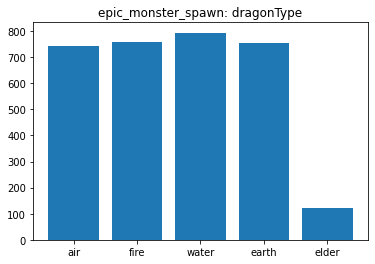

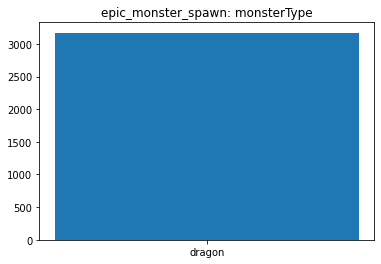

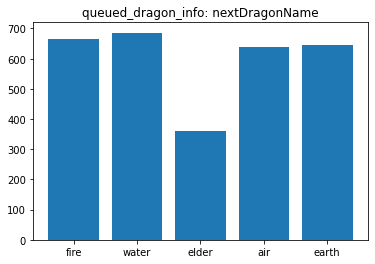

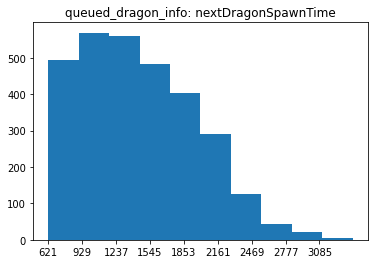

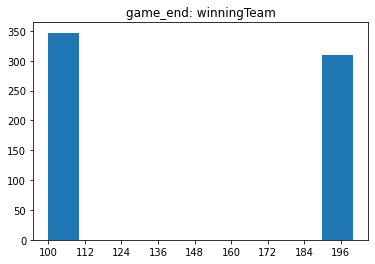

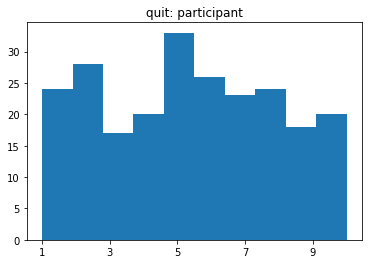

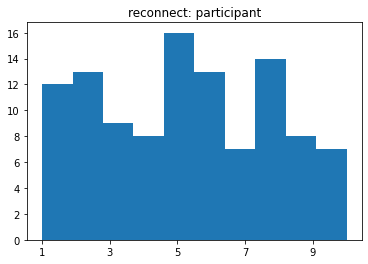

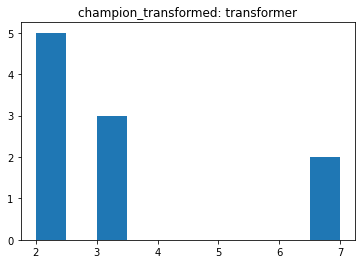

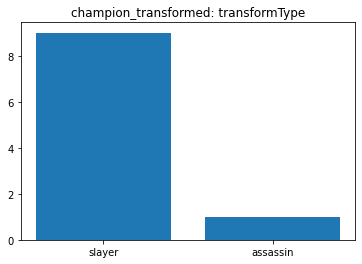

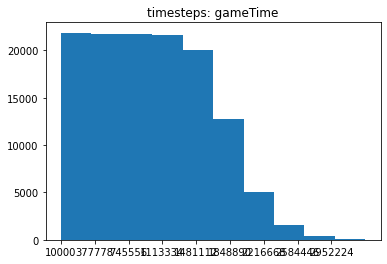

In [8]:
categorical = ['itemID', 'perkID']
figures_folder = os.path.join(output_folder, 'figs')
if not os.path.exists(figures_folder):
    os.mkdir(figures_folder)

def plot_feature(df: pd.DataFrame, state_type: str, column: str) -> None:
    title = f"{state_type}: {column}"
    dtype = df.dtypes[column]
    if column == 'position':
        plt.hist2d([i['x'] for i in df[column]], [i['z'] for i in df[column]], bins=20)
    elif dtype == np.object or dtype == np.bool or column in categorical:
        hashable_data = (item for row in df[column] for item in row) if isinstance(df[column][0], list) else df[column]
        counter = Counter(hashable_data)
        x, y = [], []
        for key, value in counter.items():
            x.append(str(key))
            y.append(value)
        if len(counter) > 10:
            plt.figure(figsize=(10 + len(counter), 8))
        plt.bar(x, y)
    elif dtype == np.int64 or dtype == np.float64:
        plt.hist(df[column])
        locs, labels = plt.xticks()
        if dtype == np.int64 and [type(loc) is float for loc in locs]:
            min, max = df[column].min(), df[column].max()
            if min != max:
                max_reasonable_ticks = 9
                ticks = np.arange(min, max + 1, ((max - min) // max_reasonable_ticks) + 1)
                plt.xticks(ticks, ticks)
    else:
        raise NotImplementedError
    plt.title(title)
    plt.savefig(os.path.join(figures_folder, f'{state_type}_{column}.png'), facecolor='white', transparent=False)
    plt.show()

for state_type in data.keys():
    df = data[state_type]['df']
    for column in df.columns:
        plot_feature(df, state_type, column)


In [4]:
turret_destroyed_times, dragon_killed_times, baron_killed_times, inhibitor_destroyed_times, game_end_times = [], [], [], [], []
for id, game, in tqdm(load_game_data(os.path.join(data_folder, 'aggregated'))):
    turret_destroyed_time, dragon_killed_time, baron_killed_time, inhibitor_destroyed_time = None, None, None, None
    format = game['format']
    for timestep_data in game['data']:
        for event_type, event in timestep_data['events']:
            if not turret_destroyed_time and event_type == 'building_destroyed' and 'turret' in event[format['events']['building_destroyed'].index('buildingType')]:
                turret_destroyed_time = timestep_data['gameTime'] / 1000 / 60
            if not dragon_killed_time and event_type == 'epic_monster_kill' and event[format['events']['epic_monster_kill'].index('monsterType')] == 'dragon':
                dragon_killed_time = timestep_data['gameTime'] / 1000 / 60
            if not baron_killed_time and event_type == 'epic_monster_kill' and event[format['events']['epic_monster_kill'].index('monsterType')] == 'baron':
                baron_killed_time = timestep_data['gameTime'] / 1000 / 60
            if not inhibitor_destroyed_time and event_type == 'building_destroyed' and event[format['events']['building_destroyed'].index('buildingType')] == 'inhibitor':
                inhibitor_destroyed_time  = timestep_data['gameTime'] / 1000 / 60
        if turret_destroyed_time and dragon_killed_time and baron_killed_time and inhibitor_destroyed_time:
            break
    turret_destroyed_times.append(turret_destroyed_time)
    dragon_killed_times.append(dragon_killed_time)
    baron_killed_times.append(baron_killed_time)
    inhibitor_destroyed_times.append(inhibitor_destroyed_time)
    game_end_times.append(game['data'][-1]['gameTime'] / 1000 / 60)


658it [01:27,  7.53it/s]


Plot event distribution over time

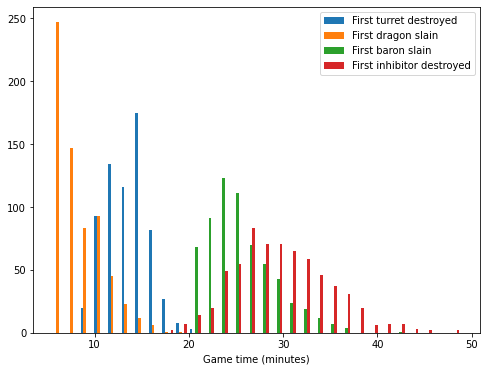

In [5]:
plt.figure(figsize=(8,6))
plt.hist([[i for i in turret_destroyed_times if i],
          [i for i in dragon_killed_times if i],
          [i for i in baron_killed_times if i],
          [i for i in inhibitor_destroyed_times if i]],
         bins=30,
         label=["First turret destroyed", "First dragon slain", "First baron slain", "First inhibitor destroyed"])
plt.xlabel("Game time (minutes)")
plt.legend()
plt.show()

Plot game stage distribution over time

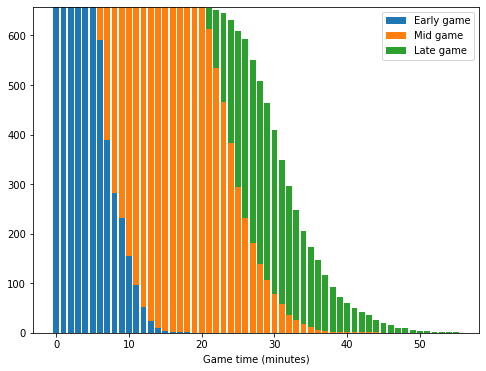

In [6]:
longest_game = math.ceil(max([i for i in game_end_times if i]))
early_game_games, mid_game_games, late_game_games = np.zeros((3, longest_game))
for i in range(len(game_end_times)):
    game_end = math.ceil(game_end_times[i])

    early_game_end = dragon_killed_times[i]
    if not early_game_end or turret_destroyed_times[i] < early_game_end:
        early_game_end = turret_destroyed_times[i]
    mid_game_end = baron_killed_times[i]
    if not mid_game_end or inhibitor_destroyed_times[i] < mid_game_end:
        mid_game_end = mid_game_end
    if early_game_end:
        early_game_end = math.ceil(early_game_end)
    else:
        early_game_end = game_end
    if mid_game_end:
        mid_game_end = math.ceil(mid_game_end)
    else:
        mid_game_end = game_end
    early_game_games[:early_game_end] += 1
    mid_game_games[early_game_end:mid_game_end] += 1
    late_game_games[mid_game_end: game_end] += 1

plt.figure(figsize=(8,6))
plt.bar(np.arange(longest_game), early_game_games, label="Early game")
plt.bar(np.arange(longest_game), mid_game_games, label="Mid game", bottom=early_game_games)
plt.bar(np.arange(longest_game), late_game_games, label="Late game", bottom=early_game_games + mid_game_games)
plt.xlabel("Game time (minutes)")
plt.legend()
plt.show()

Load data split into game phases

In [4]:
data = None
game_phases = ['early_game', 'mid_game', 'late_game']

for id, game in tqdm(load_game_data(os.path.join(data_folder, 'aggregated'))):
    format = game['format']
    # Initialize data according to the game metadata (format)
    if data is None:
        data = {game_phase: {state_type: {'columns': [column for column in format['state'][state_type]],
                             'rows': []}
                for state_type in format['state'].keys()}
                for game_phase in game_phases}
        for game_phase in game_phases:
            for event_type in format['events'].keys():
                data[game_phase][event_type] = {'columns': [column for column in format['events'][event_type]],
                                    'rows': []}
        for game_phase in game_phases:
            data[game_phase]['timesteps'] = {'columns': ['gameTime'],
                                 'rows': []}
    current_phase = 0
    for timestep_data in game['data']:
        for state_type in format['state'].keys():
            rows = [timestep_data['state'][state_type]]
            while isinstance(rows[0][0], list):
                rows = [item for row in rows for item in row]
            data[game_phases[current_phase]][state_type]['rows'].extend(rows)
        for event_type, event in timestep_data['events']:
            if current_phase < 1 and ((event_type == 'building_destroyed' and 'turret' in event[format['events']['building_destroyed'].index('buildingType')]) or
                                      (event_type == 'epic_monster_kill' and event[format['events']['epic_monster_kill'].index('monsterType')] == 'dragon')):
                current_phase = 1
            if current_phase < 2 and ((event_type == 'building_destroyed' and event[format['events']['building_destroyed'].index('buildingType')]) == 'inhibitor' or
                                      (event_type == 'epic_monster_kill' and event[format['events']['epic_monster_kill'].index('monsterType')] == 'baron')):
                current_phase = 2
            data[game_phases[current_phase]][event_type]['rows'].append(event)
        data[game_phases[current_phase]]['timesteps']['rows'].extend([timestep_data['gameTime'] for timestep_data in game['data']])

for game_phase in game_phases:
    for feature in data[game_phase].keys():
        data[game_phase][feature]['df'] = pd.DataFrame(data[game_phase][feature].pop('rows', None), columns=data[game_phase][feature]['columns'])

658it [03:34,  3.06it/s]


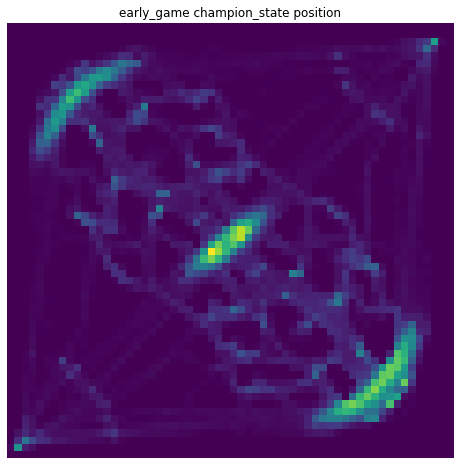

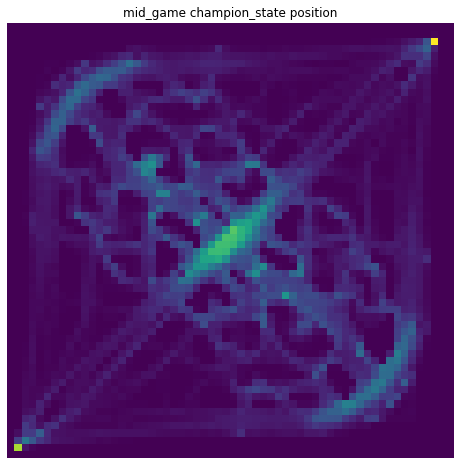

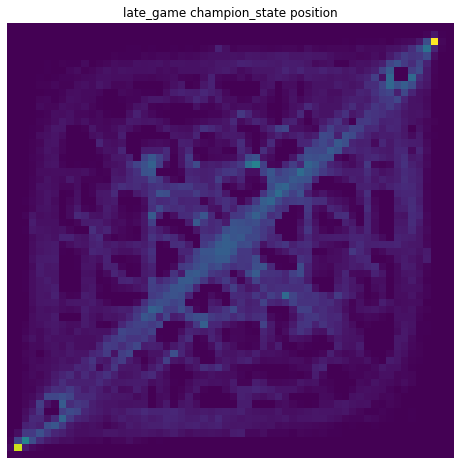

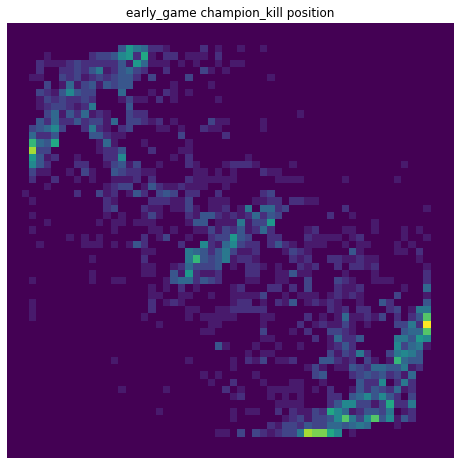

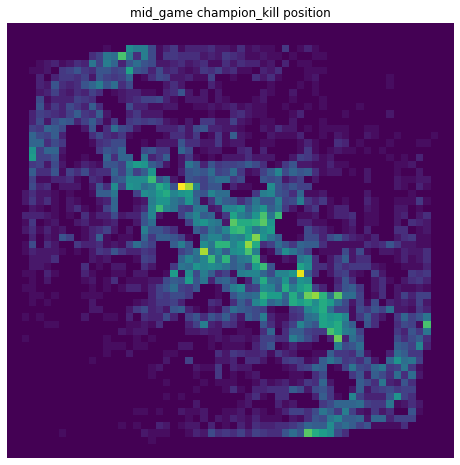

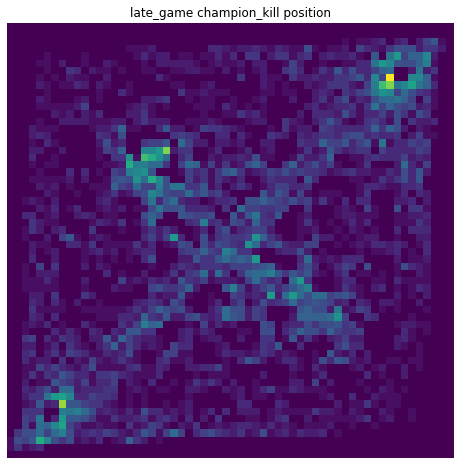

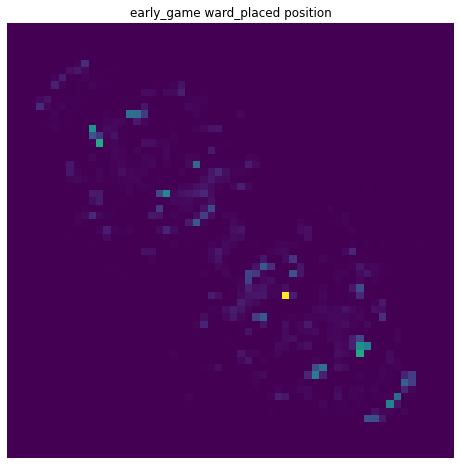

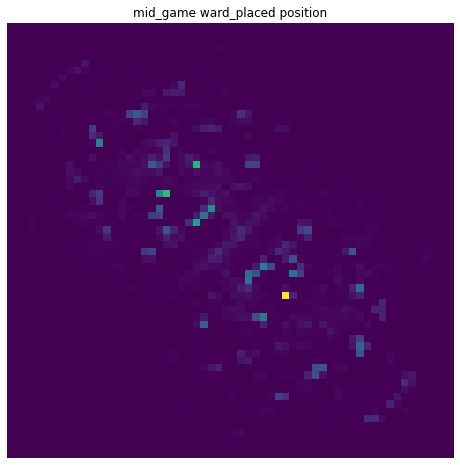

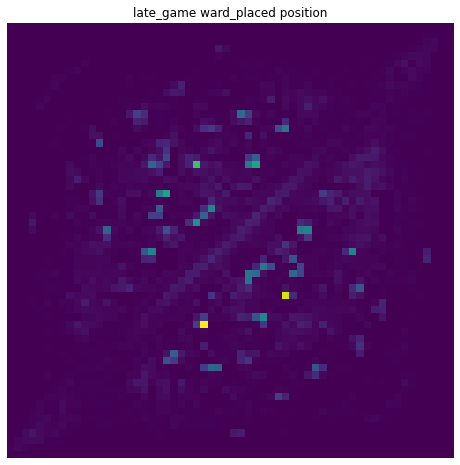

In [5]:
for feature in ('champion_state', 'champion_kill', 'ward_placed'):
    for game_phase in game_phases:
        df = data[game_phase][feature]['df']
        rows = [["", "x", "y"],
                ["min", min([i['x'] for i in df['position']]), min([i['z'] for i in df['position']])],
                ["max", max([i['x'] for i in df['position']]), max([i['z'] for i in df['position']])]]
        plt.figure(figsize=(8,8))
        plt.hist2d([i['x'] for i in df['position']], [i['z'] for i in df['position']], bins=60, range=([0, 15000], [0, 15000]))
        plt.axis('off')
        plt.savefig(os.path.join(figures_folder, f'{game_phase}_{feature}_position.png'), facecolor='white', transparent=False, bbox_inches='tight')
        plt.title(f'{game_phase} {feature} position')  # Save figures without the title
        plt.show()